# ABS Population Growth multi-measure

## Python set-up

In [1]:
# system imports
from functools import cache
from pathlib import Path

# analytic imports
import pandas as pd
from pandas import DataFrame
import numpy as np
import readabs as ra
from readabs import metacol as mc

from readabs import read_abs_series, recalibrate, qtly_to_monthly

In [2]:
# local imports
from plotting import line_plot, clear_chart_dir, set_chart_dir, plot_covid_recovery

In [3]:
# pandas display settings
pd.options.display.max_rows = 999999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# display charts in this notebook
CHART_DIR = "./CHARTS/Population/"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
clear_chart_dir(CHART_DIR)
set_chart_dir(CHART_DIR)
SHOW = False

## Download data from the ABS

In [4]:
@cache
def get_data() -> tuple[DataFrame, DataFrame]:
    """Get a dictionary of data items from the ABS
    All population data is in thousands.
    All population growth data is in thousands per year.
    All population growth rate data is in percent per year.
    Returns:
    A tuple  containing adataframe of data items, and a
    dataframe of metadata."""

    # data capture
    kags = "5206001_Key_Aggregates"
    wanted = {
        # "Series ID": ["Category ID", "single-excel-only table name", "Short Series Title"],
        "A2133251W": [
            "3101.0",
            "310101",
            "Official Estimated Resident Population (ERP)",
        ],
        "A2133255F": ["3101.0", "310101", "ERP Change Over Previous Year"],
        "A2133256J": ["3101.0", "310101", "Percentage ERP Change Over Previous Year"],
        "A84423091W": [
            "6202.0",
            "6202001",
            "Civilian population aged 15 years and over",
        ],
        "A2302460K": ["5206.0", kags, "GDP per capita: Chain volume measures (Orig)"],
        "A2302459A": [
            "5206.0",
            kags,
            "Gross domestic product: Chain volume measures (Orig)",
        ],
        "A85232568L": ["3401.0", None, "Permanent and Long-term arrivals"],
        "A85232558J": ["3401.0", None, "Permanent and Long-term departures"],
    }

    data_d, meta, seen = {}, {}, {}
    for series_id, (category_id, seo, title) in wanted.items():
        d, m = ra.read_abs_series(category_id, series_id, single_excel_only=seo)
        series = d[series_id]

        if category_id not in seen:
            seen[category_id] = series.index[-1]

        if "Q" in m[mc.freq][series_id]:
            series = ra.qtly_to_monthly(series, interpolate=False)
        data_d[title] = series
        meta[title] = m.loc[series_id]
    print("Data loaded, last period is:\n"
          + f"{'\n'.join([f'{k}: {v}' for k, v in seen.items()])}")

    # Further calculations
    data_d["Civilian population (aged 15 years+) growth"] = data_d[
        "Civilian population aged 15 years and over"
    ].diff(12)
    data_d["Civilian population (aged 15 years+) growth rate"] = (
        data_d["Civilian population aged 15 years and over"].pct_change(
            12, fill_method=None
        )
        * 100
    )

    data_d["Implicit population from National Accounts"] = (
        data_d["Gross domestic product: Chain volume measures (Orig)"]
        / data_d["GDP per capita: Chain volume measures (Orig)"]
    ) * 1_000
    data_d["Implicit population (from National Accounts) growth"] = (
        # tricky: data only has active quarters so periods=4 is correct
        data_d["Implicit population from National Accounts"].diff(periods=4)
    )
    data_d["Implicit population (from National Accounts) growth rate"] = (
        # tricky: data only has active quarters so periods=4 is correct
        data_d["Implicit population from National Accounts"].pct_change(
            periods=4, fill_method=None
        )
        * 100
    )

    data_d["12 month net permanent and long-term migration"] = (
        data_d["Permanent and Long-term arrivals"]
        - data_d["Permanent and Long-term departures"]
    ).rolling(12).sum() / 1_000

    return DataFrame(data_d), DataFrame(meta).T

## Plot

In [5]:
RECENT = 63  # months - touch over 5 years

Table 3401013 has no 'Index' sheet.
Table 3401014 has no 'Index' sheet.
Table 3401015 has no 'Index' sheet.
Table 3401016 has no 'Index' sheet.
Table 3401017 has no 'Index' sheet.
Data loaded, last period is:
3101.0: 2023Q4
6202.0: 2024-05
5206.0: 2024Q1
3401.0: 2024-05


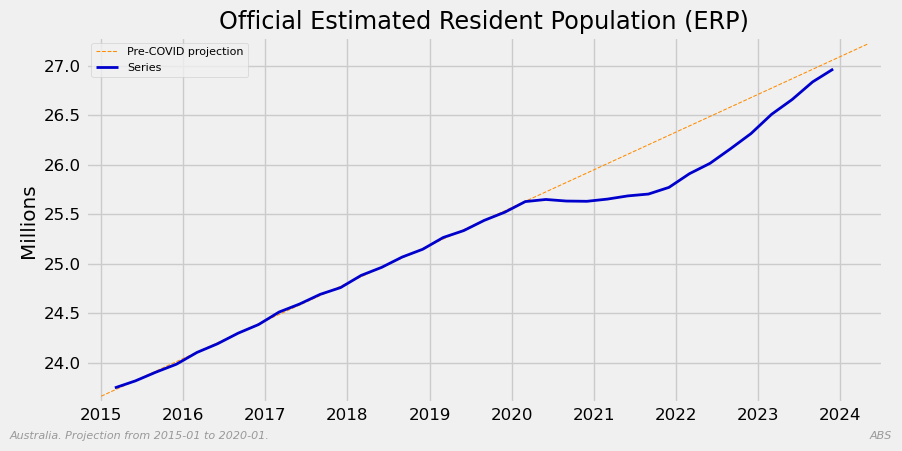

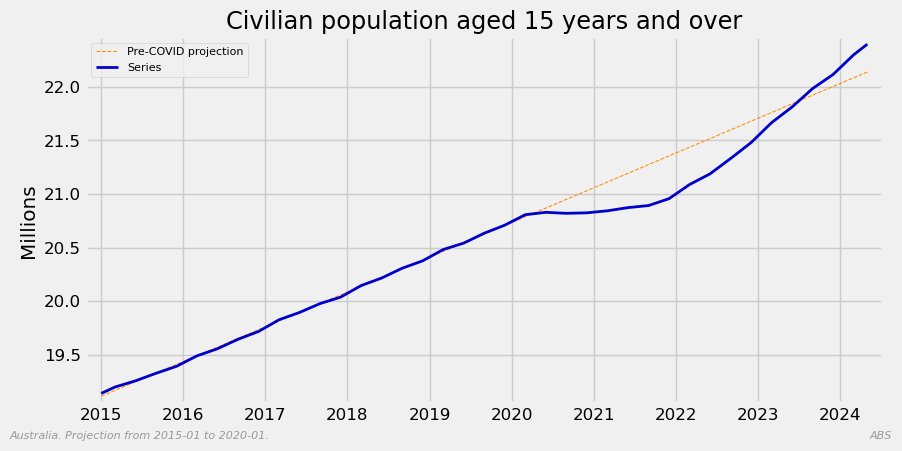

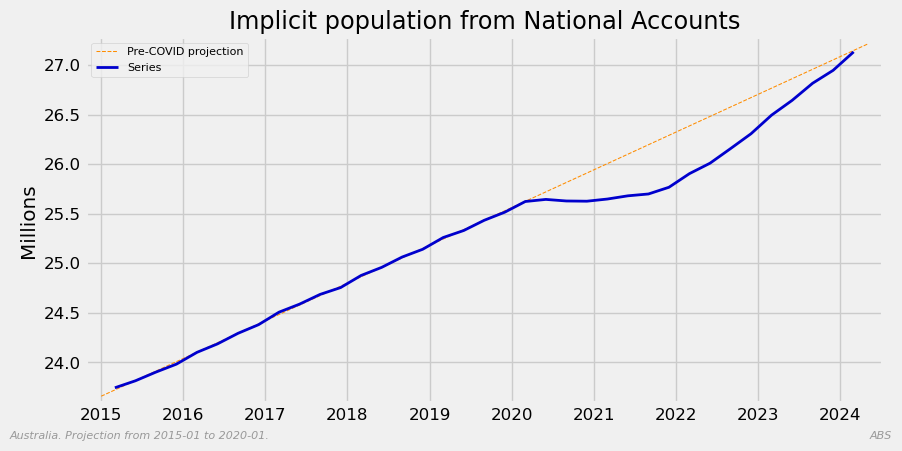

In [6]:
def plot_pop() -> None:
    """plot population estimates"""

    population = get_data()[0][
        [
            "Official Estimated Resident Population (ERP)",
            "Civilian population aged 15 years and over",
            "Implicit population from National Accounts",
        ]
    ]
    population_r, units = recalibrate(population, "Thousands")
    line_plot(
        population_r,
        starts=(None, population_r.index[-RECENT]),
        title="Population Estimates",
        ylabel=units,
        dropna=True,
        width=[2.5, 2, 1.5],
        style=["-", "--", "-."],
        lfooter="Australia. ",
        rfooter="ABS Cat. 3101.0, 6202.0, 5206.0",
        show=SHOW,
    )

    for col in population_r:
        plot_covid_recovery(
            population_r[col], 
            title=col, 
            ylabel=units,
            lfooter="Australia. ",
            rfooter="ABS",
            show=True,
        )


plot_pop()

In [7]:
def plot_growth() -> None:
    """plot population growth"""

    pop_growth_n = get_data()[0][
        [
            "ERP Change Over Previous Year",
            "Civilian population (aged 15 years+) growth",
            "Implicit population (from National Accounts) growth",
            "12 month net permanent and long-term migration",
        ]
    ]
    line_plot(
        pop_growth_n,
        title="Population Growth",
        starts=(None, pop_growth_n.index[-RECENT]),
        ylabel="Thousands per year",
        dropna=True,
        width=[3, 2.5, 2, 1.5],
        style=["-", "--", "-", ":"],
        y0=True,
        lfooter="Australia. ",
        rfooter="ABS Cat. 3101.0, 3401.0, 5206.0, 6202.0",
        show=SHOW,
    )


plot_growth()

In [8]:
def plot_growth_rate() -> None:
    """plot population growth rate"""

    pop_growth_pct = get_data()[0][
        [
            "Percentage ERP Change Over Previous Year",
            "Civilian population (aged 15 years+) growth rate",
            "Implicit population (from National Accounts) growth rate",
        ]
    ]
    line_plot(
        pop_growth_pct,
        title="Population Growth Rate",
        starts=(None, pop_growth_pct.index[-RECENT]),
        ylabel="Annual percentage change",
        dropna=True,
        width=[2, 1.5, 1],
        style=["-", "--", "-", ":"],
        y0=True,
        lfooter="Australia. ",
        rfooter="ABS Cat. 3101.0, 5206.0, 6202.0",
        show=SHOW,
    )


plot_growth_rate()

## Finished

In [9]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Sat Jul 13 2024 17:06:34

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

readabs: 0.0.8a7
pandas : 2.2.2
numpy  : 1.26.4

Watermark: 2.4.3



In [10]:
print("Finished")

Finished
